# Deep Learning 

In [257]:
# Check if we are running on colab
import subprocess
import os

def check_colab():
    """Function to check if we are running on colab. Install packages if we are."""
    try:
        import google.colab
        IN_COLAB = True
        print("Running on Colab")
        results = subprocess.run(["pip", "install", "-r", "requirements.txt"], check=True, capture_output=True)
        # Check if the installation was successful
        if results.returncode == 0:
            print("Installation successful")
            print("You may need to restart the runtime for the changes to take effect")
        else:
            print("Installation failed")
            print(results.stdout)
        
    except:
        IN_COLAB = False
        print("Not running on Colab")
    return IN_COLAB


check_colab();

Not running on Colab


# Loading Data

In [258]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import sklearn
TARGET = 'MedHouseVal'
COMPETITION = 'playground-series-s3e1'


def load_data(target = TARGET,**kwargs):
    # Load the data, turn it into tensors
    train_df = pd.read_csv('train.csv', index_col='id')
    test_df = pd.read_csv('test.csv', index_col='id')

    if kwargs.get("load_original", True):
        original = fetch_california_housing()
        ext_df = pd.DataFrame(original['data'], columns=original['feature_names'])
        ext_df[target] = original['target']
        train_df = pd.concat([ext_df,train_df])
        train_df = train_df.reset_index(drop=True)

    if kwargs.get("feature_engineering", True):
        train_df = feature_engineering(train_df)
        test_df = feature_engineering(test_df)

    print("Training Size:", train_df.shape)
    print("Test Size:", test_df.shape)

    FEATURES = [col for col in train_df.columns if col not in ['id', target]]
    print("Num Features:", len(FEATURES))


    train_tensors = torch.tensor(train_df[FEATURES].values, dtype=torch.float32)
    target_tensors = torch.tensor(train_df[target].values, dtype=torch.float32)
    test_tensors = torch.tensor(test_df[FEATURES].values, dtype=torch.float32)
    output_dict = {
        "train_df": train_df,
        "test_df": test_df,
        "train_tensors": train_tensors,
        "target_tensors": target_tensors,
        "test_tensors": test_tensors,
    }
    return output_dict

def feature_engineering(df,**kwargs):
    df['number_houses_per_block'] = df['Population'] / df['AveOccup']
    df['total_income_of_block'] = df['MedInc'] * df['Population']
    df['occupants_to_bedrooms'] = df['AveOccup'] / df['AveBedrms']
    df['total_number_of_rooms'] = df['AveBedrms'] + df['AveRooms']
    df['bedrooms_to_rooms'] = df['AveBedrms'] / df['AveRooms']
    df['occupants_to_rooms'] = df['AveOccup'] / df['AveRooms']
    # Set target to last col in training df
    cols = list(df.columns)
    if TARGET in cols:
        cols.remove(TARGET)
        cols.append(TARGET)
        df = df[cols]

    return df

load_dict = load_data()

train_df = load_dict['train_df']
test_df = load_dict['test_df']

Training Size: (57777, 15)
Test Size: (24759, 14)
Num Features: 14


# EDA

In [259]:
# Simple EDA
# Plot histogram of the training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57777 entries, 0 to 57776
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MedInc                   57777 non-null  float64
 1   HouseAge                 57777 non-null  float64
 2   AveRooms                 57777 non-null  float64
 3   AveBedrms                57777 non-null  float64
 4   Population               57777 non-null  float64
 5   AveOccup                 57777 non-null  float64
 6   Latitude                 57777 non-null  float64
 7   Longitude                57777 non-null  float64
 8   number_houses_per_block  57777 non-null  float64
 9   total_income_of_block    57777 non-null  float64
 10  occupants_to_bedrooms    57777 non-null  float64
 11  total_number_of_rooms    57777 non-null  float64
 12  bedrooms_to_rooms        57777 non-null  float64
 13  occupants_to_rooms       57777 non-null  float64
 14  MedHouseVal           

In [260]:
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,number_houses_per_block,total_income_of_block,occupants_to_bedrooms,total_number_of_rooms,bedrooms_to_rooms,occupants_to_rooms,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,126.0,2680.7144,2.496124,8.007937,0.146591,0.365909,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1138.0,19931.6614,2.170886,7.210018,0.155797,0.338217,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,177.0,3599.6704,2.610526,9.361582,0.129516,0.338105,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,219.0,3148.8498,2.374468,6.890411,0.184458,0.437991,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,259.0,2173.1030,2.017857,7.362934,0.172096,0.347265,3.422


In [261]:
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,number_houses_per_block,total_income_of_block,occupants_to_bedrooms,total_number_of_rooms,bedrooms_to_rooms,occupants_to_rooms,MedHouseVal
count,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000
mean,3.858046,26.979559,5.258104,1.074519,1576.720610,2.916770,35.592118,-119.559822,571.008784,6072.805300,2.763741,6.332623,0.215679,0.592257,2.075753
std,1.838287,12.374508,1.771502,0.294086,1249.494223,6.575793,2.102374,1.984615,462.628574,6050.581722,7.125569,1.991263,0.057186,1.759034,1.156927
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.598677,1.608000,0.070450,1.388889,0.087521,0.018109,0.149990
25%,2.588200,17.000000,4.381443,1.015306,882.000000,2.407625,33.930000,-121.800000,320.776613,2837.775600,2.241860,5.439597,0.177577,0.439960,1.203000
50%,3.521400,26.000000,5.126761,1.052941,1316.000000,2.769231,34.210000,-118.460000,464.692483,4568.000000,2.636388,6.184608,0.206408,0.517532,1.804000
75%,4.710900,36.000000,5.936031,1.091837,1815.000000,3.179673,37.700000,-118.020000,669.737526,7232.772000,3.061224,6.990338,0.243396,0.644609,2.657000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,14325.614035,183123.592200,1492.000000,167.545455,1.000000,392.631579,5.000010


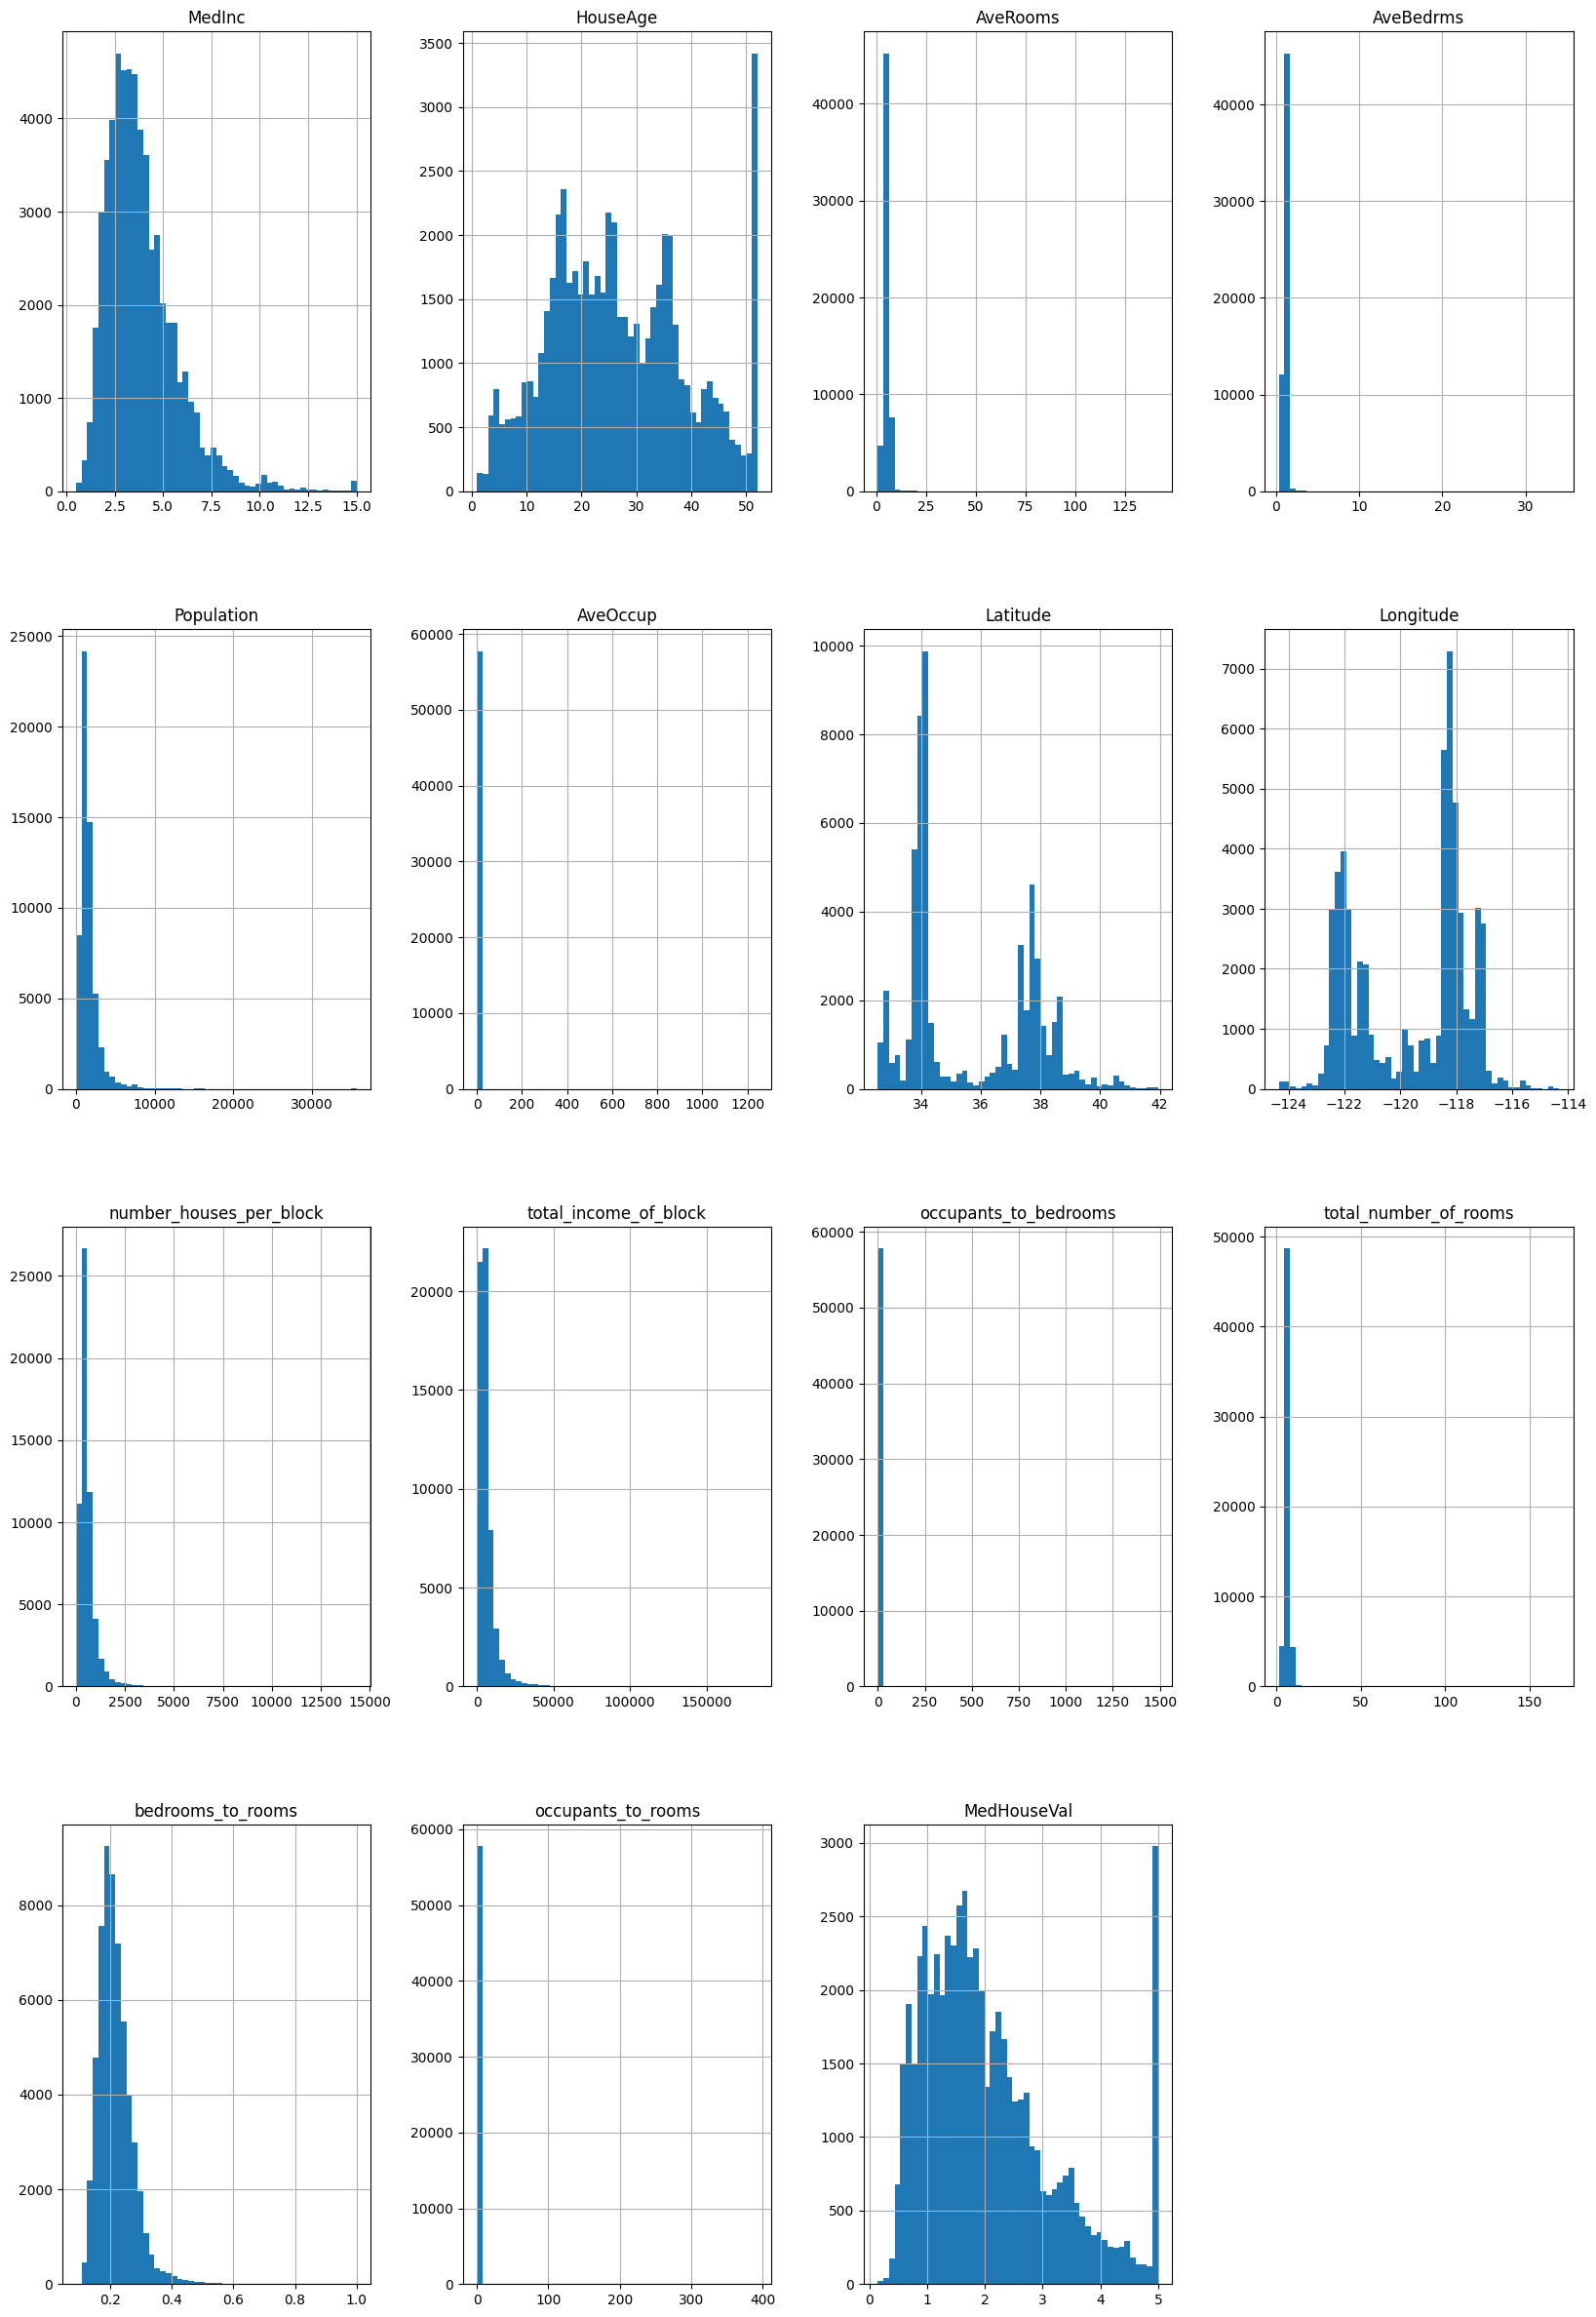

In [262]:
train_df.hist(bins=50, figsize=(20,30));

In [263]:
train_df.corrwith(train_df[TARGET]).abs().sort_values(ascending=False)

MedHouseVal                1.000000
MedInc                     0.696527
bedrooms_to_rooms          0.274744
total_income_of_block      0.263636
AveRooms                   0.236013
total_number_of_rooms      0.203862
Latitude                   0.126553
HouseAge                   0.103085
Longitude                  0.052846
occupants_to_rooms         0.046358
AveBedrms                  0.041327
number_houses_per_block    0.035953
Population                 0.033360
AveOccup                   0.026262
occupants_to_bedrooms      0.020993
dtype: float64

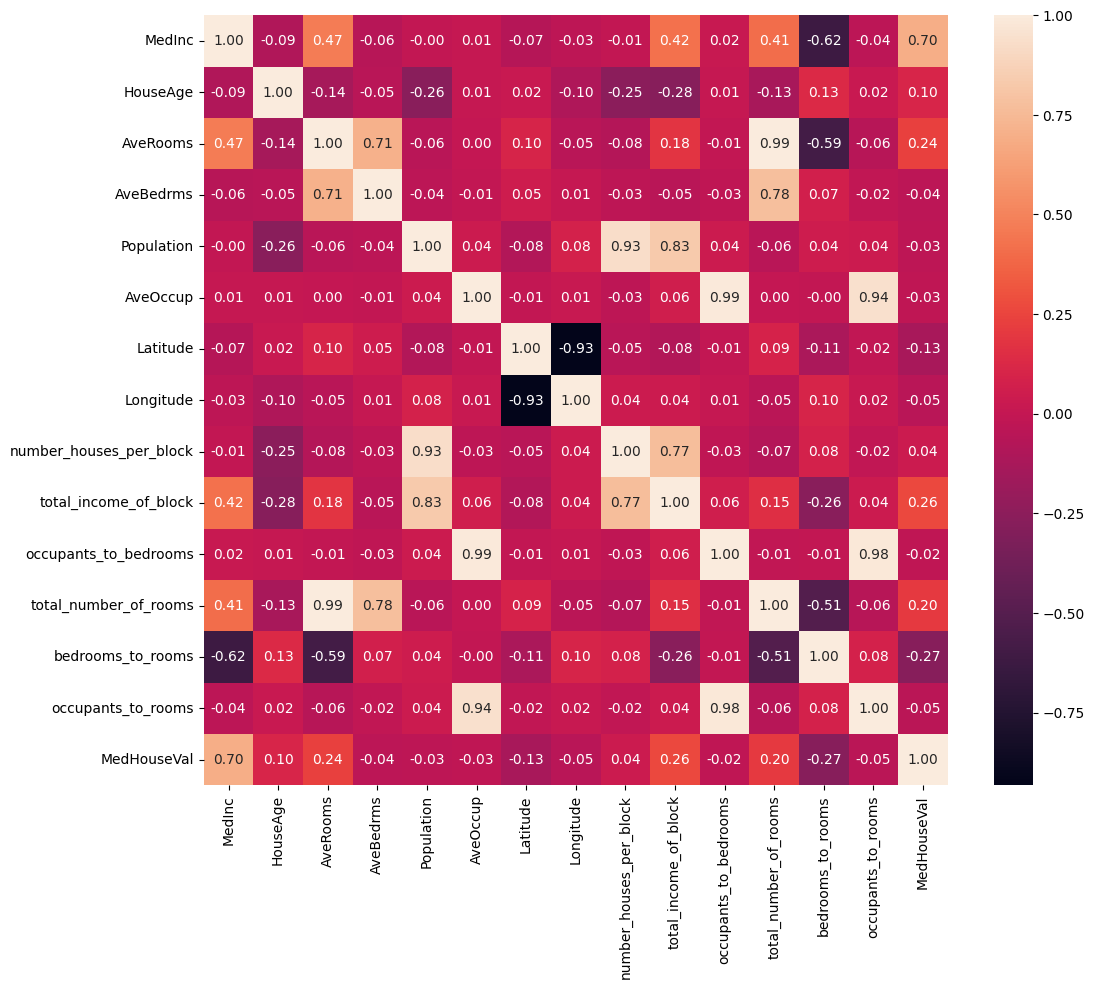

In [264]:
# Plot correlation matrix
import seaborn as sns
corr_matrix = train_df.corr()
corr_matrix[TARGET].abs().sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f");

# Preprocessing Data

In [274]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
def sklearn_standardize(train_df,test_df,target = TARGET):
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(train_df.drop(target,axis=1))
    x_df = train_df.drop(target,axis=1)
    x_df = scaler.transform(x_df)
    x_df = pd.DataFrame(x_df,columns=train_df.drop(target,axis=1).columns)
    y_df = train_df[target]
    y_df = pd.DataFrame(y_df,columns=[target])
    x_test_df = test_df.copy()
    x_test_df = scaler.transform(x_test_df)
    x_test_df = pd.DataFrame(x_test_df,columns=test_df.columns)
    return x_df, y_df, x_test_df

x_df, y_df, x_test_df = sklearn_standardize(train_df,test_df)

In [267]:
train_df.shape,tmp.shape

((57777, 15), (57777, 14))

In [205]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def detect_outliers(data, contamination=0.1):
    """
    A function that uses both Isolation Forest and Local Outlier Factor for outlier detection.
    
    Parameters:
    - data: a 2D numpy array or pandas DataFrame containing the data to be analyzed
    - contamination: the percentage of outliers in the data (default: 0.1)
    
    Returns:
    - outliers: a 1D numpy array containing the indices of the outliers in the data
    """
    
    # Fit the Isolation Forest model
    model_if = IsolationForest(random_state=42)
    model_if.fit(data.values)
    predictions_if = model_if.predict(data.values)
    
    # Fit the Local Outlier Factor model
    model_lof = LocalOutlierFactor()
    predictions_lof = model_lof.fit_predict(data)
    
    # Combine the predictions from both models
    combined_predictions = np.where(predictions_if == -1, -1, predictions_lof)
    
    # Extract the indices of the outliers
    outliers = np.where(combined_predictions == -1)[0]
    
    return outliers, predictions_if, predictions_lof

# Detect outliers
outliers, predictions_if, predictions_lof = detect_outliers(train_df.drop(TARGET, axis=1), contamination=0.1)

# remove outliers from df 
train_df_outliers = train_df.drop(outliers, axis=0).reset_index(drop=True)
# Drop just if
# train_df_outliers = train_df.drop(np.where(predictions_if == -1)[0], axis=0).reset_index(drop=True)
# Drop just lof
# train_df_outliers = train_df.drop(np.where(predictions_lof == -1)[0], axis=0).reset_index(drop=True)

# Test z score
from scipy import stats
import numpy as np
from scipy.stats import zscore
def detect_outliers_zscore(data, threshold=3):
    z_scores = zscore(data)
    outliers = np.where(np.abs(z_scores) > threshold)
    return outliers[0]

outliers_zscore = detect_outliers_zscore(train_df.drop(TARGET, axis=1), threshold=3)

# remove outliers from df
train_df_outliers_zscore = train_df.drop(outliers_zscore, axis=0).reset_index(drop=True)

In [168]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import sklearn



TARGET = 'MedHouseVal'
COMPETITION = 'playground-series-s3e1'

def train_val_split(input_tensors,targets, val_size=0.1, random_seed=0, true_random=False):
    """Splits the input tensors into train and validation sets. 
    Returns the train and validation sets as tensors.
    """
    num_samples = input_tensors.shape[0]
    indices = list(range(num_samples))
    split = int(np.floor(val_size * num_samples))
    if true_random:
        random_seed = np.random.randint(0, 1000)
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_tensors = input_tensors[train_indices]
    val_tensors = input_tensors[val_indices]
    train_targets = targets[train_indices]
    val_targets = targets[val_indices]

    print("Train Size:", train_tensors.shape)
    print("Val Size:", val_tensors.shape)

    if train_tensors.shape[0] + val_tensors.shape[0] != input_tensors.shape[0]:
        raise ValueError("Train and val sizes don't add up to input size")

    if train_tensors.shape[0] != train_targets.shape[0]:
        raise ValueError("Train tensors and targets don't match")

    return train_tensors, val_tensors, train_targets, val_targets

def load_data(target,**kwargs):
    # Load the data, turn it into tensors
    train_df = pd.read_csv('train.csv', index_col='id')
    test_df = pd.read_csv('test.csv', index_col='id')

    if kwargs.get("load_original", True):
        original = fetch_california_housing()
        ext_df = pd.DataFrame(original['data'], columns=original['feature_names'])
        ext_df[target] = original['target']
        train_df = pd.concat([ext_df,train_df])
        train_df = train_df.reset_index(drop=True)

    # train_df['number_houses_per_block'] = train_df['Population'] / train_df['AveOccup']
    # train_df['total_income_of_block'] = train_df['MedInc'] * train_df['Population']
    # train_df['occupants_to_bedrooms'] = train_df['AveOccup'] / train_df['AveBedrms']
    # train_df['total_number_of_rooms'] = train_df['AveBedrms'] + train_df['AveRooms']
    # train_df['bedrooms_to_rooms'] = train_df['AveBedrms'] / train_df['AveRooms']
    # train_df['occupants_to_rooms'] = train_df['AveOccup'] / train_df['AveRooms']

    # test_df['number_houses_per_block'] = test_df['Population'] / test_df['AveOccup']
    # test_df['total_income_of_block'] = test_df['MedInc'] * test_df['Population']
    # test_df['occupants_to_bedrooms'] = test_df['AveOccup'] / test_df['AveBedrms']
    # test_df['total_number_of_rooms'] = test_df['AveBedrms'] + test_df['AveRooms']
    # test_df['bedrooms_to_rooms'] = test_df['AveBedrms'] / test_df['AveRooms']
    # test_df['occupants_to_rooms'] = test_df['AveOccup'] / test_df['AveRooms']

    print("Training Size:", train_df.shape)
    print("Test Size:", test_df.shape)

    FEATURES = [col for col in train_df.columns if col not in ['id', target]]
    print("Num Features:", len(FEATURES))


    train_tensors = torch.tensor(train_df[FEATURES].values, dtype=torch.float32)
    target_tensors = torch.tensor(train_df[target].values, dtype=torch.float32)
    test_tensors = torch.tensor(test_df[FEATURES].values, dtype=torch.float32)
    output_dict = {
        "train_df": train_df,
        "test_df": test_df,
        "train_tensors": train_tensors,
        "target_tensors": target_tensors,
        "test_tensors": test_tensors,
    }
    return output_dict

def get_device(whacky_mode = False):
    # Get the device to train on
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and whacky_mode:
        return torch.device("mps")
    else:
        return torch.device("cpu")

def torch_standardize(x):
    mean = torch.mean(x, dim=0)
    std = torch.std(x, dim=0)
    return ((x - mean) / std, mean, std)

def plot_loss(**kwargs):
    """Plots the loss and accuracy of the model"""
    # Get loss and accuracy from kwargs
    loss_vals_ = kwargs.get('loss_vals', loss_vals)

    # Get epochs to plot
    total_epochs_shown = kwargs.get('epochs', 0)

    loss_vals_ = loss_vals_[-total_epochs_shown:]
    
    plt.plot(loss_vals_, label="Loss", color="green", linestyle="dashed", marker="o")
    plt.legend()
    # Add title to x axis
    plt.xlabel("Epochs")
    # Add title to y axis
    plt.ylabel("Loss")
    # Add title to graph
    plt.title("Loss vs Epochs")
    # Only show integer epochs 
    # Set y-axis to log scale
    plt.yscale("log")

    # Plot accuracy in a seperate plot 
    plt.figure()
    # Plot

# Preprocess the data
def preprocess(train_tensors, val_tensors, test_tensors, include_original=True):
    """Function for preprocessing the data before training. Currently normalizing,
    standardizing, and keeping the original values for the neural network. We 
    will pass all three concatenated to our model, and let it decide which ones
    to use.
    We will L2, L1 normalize and min/max normalize the features of x.
    For now we will focus on standardizing the data, and later we will add more
    """
    original_train_tensors = train_tensors
    original_val_tensors = val_tensors
    original_test_tensors = test_tensors

    train_tensors, train_mean, train_std = torch_standardize(train_tensors)
    val_tensors = (val_tensors - train_mean) / train_std
    test_tensors = (test_tensors - train_mean) / train_std

    if include_original:
        train_tensors = torch.cat((train_tensors, original_train_tensors), dim=1)
        val_tensors = torch.cat((val_tensors, original_val_tensors), dim=1)
        test_tensors = torch.cat((test_tensors, original_test_tensors), dim=1)
    
    return train_tensors, val_tensors, test_tensors

def submit_kaggle(**kwargs):
    """Function for submitting a file to a kaggle competition. The function
    will return the output of the kaggle cli command as a string."""

    kaggle_cli = kwargs.get("kaggle_cli",'/Users/dbless/Library/Python/3.11/bin/kaggle')
    competition = kwargs.get("competition","playground-series-s3e1")
    submission = kwargs.get("submission","submission.csv")
    message = kwargs.get("message","Statistics may be dull, but it has its moments.")

    result = subprocess.run(['./submit_kaggle.sh',kaggle_cli,competition,submission,message],cwd=os.getcwd(), capture_output=True, text=True)

    if hasattr(result, 'stderr'):
        print(result.stderr)
        
    if result.returncode == 0:
        print("Submission successful")
        
    if hasattr(result, 'stdout'):
        print(result.stdout)

    return result

class HousingDataset(Dataset):
    """Housing dataset."""

    def __init__(self, x, y=None):
        self.x = x
        self.y = y if y is not None else None

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] if self.y is not None else torch.empty((1, 1), dtype=torch.float32)

def main_load(*args,**kwargs):

    if kwargs.get("whacky_mode",False):
        print("Whacky mode activated")

        train_dataset = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32))
        # Split train dataset
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        # Data loaders
        # Get batch size if in kwargs
        batch_size = kwargs.get('batch_size', 2500)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)      
        print("Train dataloader batch size", train_loader.batch_size)
        # Wrap outputs in a dictionary
        output = {
            'train_tensors': X,
            'val_tensors': y,
            'test_tensors': X_test,
            'train_dataset': train_dataset,
            'val_dataset': val_dataset,
            'test_dataset': test_dataset,
            "train_loader": train_loader,
            "val_loader": val_loader,
            "test_loader": test_loader
        }
        return output


        

    # Get target if in kwargs
    target = kwargs.get('target', TARGET)

    # Load data
    load_dict = load_data(target,**kwargs)
    train_tensors = load_dict['train_tensors']
    target_tensors = load_dict['target_tensors']
    test_tensors = load_dict['test_tensors']
    


    # Get val_size, random seed and true random if in kwargs
    val_size = kwargs.get('val_size', 0.1)
    random_seed = kwargs.get('random_seed', 42)
    true_random = kwargs.get('true_random', False)
    train_tensors, val_tensors, train_targets, val_targets = train_val_split(train_tensors, target_tensors, val_size, random_seed, true_random)
    include_original = kwargs.get('include_original', False)
    train_tensors, val_tensors, test_tensors = preprocess(train_tensors, val_tensors, test_tensors,include_original=include_original)
    train_dataset = TensorDataset(train_tensors, train_targets)
    val_dataset = TensorDataset(val_tensors, val_targets)
    test_dataset = TensorDataset(test_tensors)

    # Data loaders
    # Get batch size if in kwargs
    batch_size = kwargs.get('batch_size', 256)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Train dataloader batch size", train_loader.batch_size)

    # Wrap outputs in a dictionary
    output = {
        'train_tensors': train_tensors,
        'val_tensors': val_tensors,
        'train_targets': train_targets,
        'val_targets': val_targets,
        'test_tensors': test_tensors,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader
    }
    return output

data_dict = main_load()

Training Size: (57777, 9)
Test Size: (24759, 8)
Num Features: 8
Train Size: torch.Size([52000, 8])
Val Size: torch.Size([5777, 8])
Train dataloader batch size 256


In [48]:
# Define model
class HousePricesModel(nn.Module):
    def __init__(self):
        super(HousePricesModel, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(8, 12),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(12, 8),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )


    def forward(self, x):
        return self.head(x)
    
def train(model, train_dl, val_dl, optimizer, loss_func, epochs, device):
    loss_vals = []
    print("-"*30)
    print(f"Training model: {model.__class__.__name__}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Epochs: {epochs}")
    print()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            y_hat = model(xb)
            y_hat = y_hat.squeeze()
            loss = loss_func(y_hat, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss = 0
            for xb, yb in val_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                
                y_hat = model(xb)
                y_hat = y_hat.squeeze()
                loss = loss_func(y_hat, yb)
                tot_loss += loss.item() 
            val_loss = tot_loss / len(val_dl)
            print(f"Epoch: {epoch}")
            print(f"Validation loss: {val_loss}")
            print()
            loss_vals.append(val_loss)

    return loss_vals

def train_model(*args, **kwargs):
    """Function for training a model. We will use this function to train the
    model with the optimal hyperparameters found in the hyperparameter search."""

    # Get model, optimizer, loss function and dataloaders from kwargs, or use default values
    device = kwargs.get('dev', get_device())
    model = kwargs.get('model',HousePricesModel()).to(device)
    lr = kwargs.get('lr', 0.001)
    weight_decay = kwargs.get('weight_decay', 0)
    optimizer = kwargs.get('optimizer',optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay))
    loss_func = kwargs.get('loss_func', nn.MSELoss(reduction='mean'))
    train_dl = kwargs.get('train_dl',data_dict['train_loader'])
    val_dl = kwargs.get('val_dl',data_dict['val_loader'])
    epochs = kwargs.get('epochs', 100)

    # Train model
    input_model_dict = dict(model=model, optimizer=optimizer, loss_func=loss_func, train_dl=train_dl, val_dl=val_dl, epochs=epochs, device=device)

    return train(**input_model_dict),model

# Get model predictions
def make_predictions(model,**kwargs):
    device = kwargs.get('device', get_device())
    test_dl = kwargs.get('test_dl', data_dict['test_loader'])
    model.eval()
    with torch.no_grad():
        tot_loss = 0
        preds = []
        for xb in test_dl:
            xb = xb[0]
            xb = xb.to(device)
            y_hat = model(xb)
            y_hat = y_hat.squeeze()
            preds.append(y_hat)
        preds = torch.cat(preds)
        preds = preds.cpu().numpy()

    # Check preds are correct shape
    correct_num_of_preds = kwargs.get('correct_num_of_preds', data_dict['test_tensors'].shape[0])
    if preds.shape[0] != correct_num_of_preds:
        raise ValueError(f"Expected {correct_num_of_preds} predictions, but got {preds.shape[0]} predictions")
    return preds

def save_predictions(preds, **kwargs):
    # Save predictions to csv file
    filename = kwargs.get('filename', 'submission.csv')
    target = kwargs.get('target', TARGET)
    # Copy Ids from sample submission
    df = pd.read_csv('sample_submission.csv')
    df[target] = preds

    # Make sure we have two columns in df
    assert df.shape[1] == 2, f"Expected df to have 2 columns, but got {df.shape[1]} columns"
    df.to_csv(filename, index=False)
    return

def make_and_save_predictions(model, **kwargs):
    preds = make_predictions(model, **kwargs)
    save_predictions(preds, **kwargs)

    return preds

def main_submit(model,**kwargs):
    make_and_save_predictions(model,**kwargs)
    submit_kaggle(**kwargs)
    return

# Train model
device = get_device(whacky_mode=False)
data_dict = main_load()
loss_vals,model = train_model(weight_decay=0.0001,epochs=1000,device=device)

Training Size: (57777, 10)
Test Size: (24759, 9)
Num Features: 8
Train Size: torch.Size([52000, 8])
Val Size: torch.Size([5777, 8])
Train dataloader batch size 256
------------------------------
Training model: HousePricesModel
Optimizer: Adam
Epochs: 1000

Epoch: 0
Validation loss: 3.017238772433737

Epoch: 1
Validation loss: 0.5238696686599565

Epoch: 2
Validation loss: 0.45480901909911114

Epoch: 3
Validation loss: 0.4325836236062257

Epoch: 4
Validation loss: 0.42276467836421466

Epoch: 5
Validation loss: 0.41189745975577313

Epoch: 6
Validation loss: 0.4062297460825547

Epoch: 7
Validation loss: 0.39994373399278393

Epoch: 8
Validation loss: 0.3950727167336837

Epoch: 9
Validation loss: 0.3917537137218144

Epoch: 10
Validation loss: 0.38932151120641956

Epoch: 11
Validation loss: 0.39136644031690515

Epoch: 12
Validation loss: 0.38823009444319684

Epoch: 13
Validation loss: 0.3824613949526911

Epoch: 14
Validation loss: 0.38042433106380963

Epoch: 15
Validation loss: 0.37907644328

In [50]:
main_submit(model,message="Extra data, 1000 epochs, standardizing, 256 batch size.")


  0%|          | 0.00/383k [00:00<?, ?B/s]
  2%|▏         | 8.00k/383k [00:00<00:07, 51.7kB/s]
 71%|███████   | 272k/383k [00:00<00:00, 1.28MB/s] 
100%|██████████| 383k/383k [00:02<00:00, 169kB/s] 

Submission successful
Successfully submitted to Playground Series - Season 3, Episode 1
